In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

/home/zahir/Tf_gpu/tfgpu1/lib/python3.12/site-packages/seaborn/_statistics.py:32: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 2.3.2)
  from scipy.stats import gaussian_kde


In [2]:
df = pd.read_csv("train.csv")

In [3]:
df.shape

(404290, 6)

In [4]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [6]:
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [7]:
# Duplicate rows
df.duplicated().sum()

np.int64(0)

is_duplicate
0    255027
1    149263
Name: count, dtype: int64
is_duplicate
0    63.080215
1    36.919785
Name: count, dtype: float64


<Axes: xlabel='is_duplicate'>

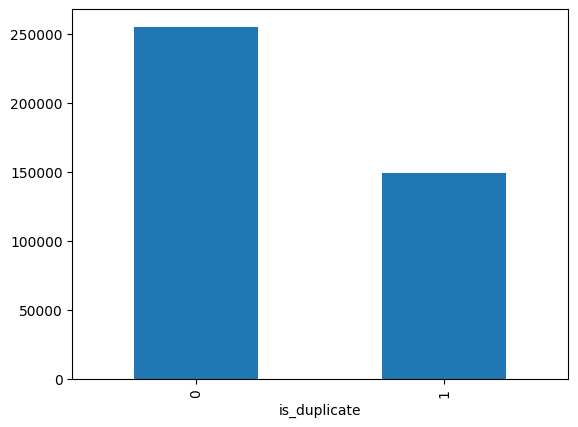

In [8]:
# Distribution of duplicate and non-duplicate questions
print(df['is_duplicate'].value_counts())
print((df['is_duplicate'].value_counts()/df['is_duplicate'].count())*100)
df['is_duplicate'].value_counts().plot(kind='bar')

In [9]:
# Repeated questions
qid = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
print('Number of unique questions : ',np.unique(qid).shape[0])
x = qid.value_counts()>1
print('Number of questions getting repeated : ',x[x].shape[0])

Number of unique questions :  537933
Number of questions getting repeated :  111780


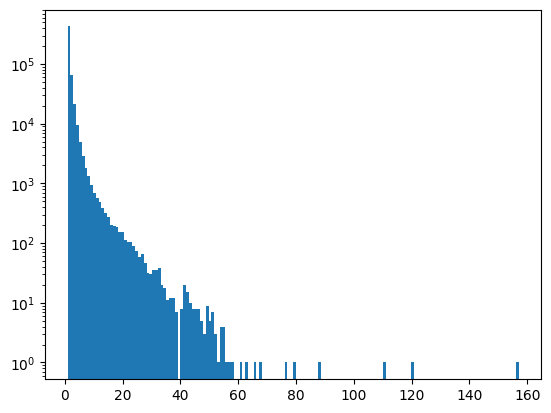

In [10]:
# Repeated questions in histogram
plt.hist(qid.value_counts().values,bins=160)
plt.yscale('log')
plt.show()

In [11]:
df = df.dropna()

In [12]:
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

In [13]:
new_df = df.sample(30000)

In [14]:
new_df.shape

(30000, 6)

In [15]:
new_df.duplicated().sum()

np.int64(0)

In [16]:
ques_df = new_df[['question1','question2']]
ques_df.head()

,question1,question2
300167,King of USA?,How do I display mysite.com/post.php?post=X as...
239934,What are your new year resolutions for 2017?,What would be your New Year resolutions for 2017?
252988,How can I improve my overall score to 79+ in PTE?,How can I improve my PTE score to 79+?
403869,What does it mean when a girl says you’re crazy?,What does that mean if a girl calls you crazy?
21321,What exactly is the Cauvery water dispute?,What is Cauvery water dispute between Tamilnad...


In [17]:
from sklearn.feature_extraction.text import CountVectorizer
# Merge texts
questions = list(ques_df['question1']) + list(ques_df['question2'])
cv = CountVectorizer(max_features=3000)
q1_arr,q2_arr = np.vsplit(cv.fit_transform(questions).toarray(),2)

In [18]:
temp_df1 = pd.DataFrame(q1_arr,index=ques_df.index)
temp_df2 = pd.DataFrame(q2_arr,index=ques_df.index)
temp_df = pd.concat([temp_df1,temp_df2],axis=1)
temp_df.shape

(30000, 6000)

In [19]:
temp_df.head()

,0,1,2,3,4,5,6,7,8,9,...,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
300167,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
239934,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
252988,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
403869,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
21321,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
temp_df['is_duplicate'] = new_df['is_duplicate']

In [21]:
temp_df.shape

(30000, 6001)

In [22]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(temp_df.iloc[:,0:-1].values,temp_df.iloc[:,-1].values,test_size=0.2,random_state=1)

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf = RandomForestClassifier()
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
accuracy_score(y_test,y_pred)

0.7371666666666666

In [30]:
from xgboost import XGBClassifier

xgb = XGBClassifier()
xgb.fit(X_train,y_train)
y_pred1 = xgb.predict(X_test)
accuracy_score(y_test,y_pred1)

0.7203333333333334